In [1]:
# automatic reloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
import openai
import pandas as pd
import numpy as np

In [3]:
# print the entire output of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# also print the entire content of a dfs column
pd.set_option('display.max_colwidth', None)

In [4]:
from zero_shot_models.cgpt import read_data

In [5]:
path_to_data = 'test_cgpt_binary_context.csv'
test = pd.read_csv(path_to_data)

path_to_data = 'valid_cgpt_binary_context.csv'
valid = pd.read_csv(path_to_data)

# path_to_data = '../data/liar_dataset/train.tsv'
# train = read_data(path_to_data)


In [6]:
labels_map = {'pants-fire': "false", 'false':"false", 'barely-true':"false", 'half-true':"false", 'mostly-true':"true", 'true':"true"}
reversed_labels_map = {v: k for k, v in labels_map.items()}

In [7]:
valid.label.value_counts()

False    864
True     420
Name: label, dtype: int64

In [8]:
valid.prediction.value_counts()

False    1041
True      243
Name: prediction, dtype: int64

In [9]:
test.label.value_counts()

False    818
True     449
Name: label, dtype: int64

In [10]:
test.prediction.value_counts()

False    972
True     295
Name: prediction, dtype: int64

# Length features

In [11]:
def get_sent_legnths(sent):
    """Get number of words and characters in a sentence.
    Args:
        sent (str): Sentence.
    Returns:
        (int, int): Number of words and characters in the sentence.
    
    Example:
        >>> sent = "This is a sentence."
        >>> get_sent_legnths(sent)
        (4, 20)
    """
    return len(sent.split()), len(sent)

def get_sent_legnths_df(df, text_col='statement'):
    """Get number of words and characters in a sentence.
    Args:
        df (pd.DataFrame): Dataframe with text column.
        text_col (str): Name of the text column.
    Returns:
        (int, int): Number of words and characters in the sentence.
    
    Example:
        >>> sent = "This is a sentence."
        >>> get_sent_legnths_df(sent)
        (4, 20)
    """
    df['num_words'], df['num_chars'] = zip(*df[text_col].apply(get_sent_legnths))
    return df

# Perplexity

In [12]:
import nltk
from nltk.lm import MLE
from nltk.lm import Vocabulary


In [13]:
def preb_sentence(sentence):
    sentence = sentence.lower()
    tokens = nltk.word_tokenize(sentence)
    bigrams = nltk.bigrams(tokens, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<\s>')
    return list(bigrams)

def get_vocab(train_data):
    words = [word for sent in train_data for word in sent]
    words.extend(['<s>', '<\s>'])
    vocab = Vocabulary(words, unk_cutoff=1)
    return vocab


def train_fit_model(train_data, vocab):
    model = MLE(2)
    model.fit(train_data, vocab)
    return model

def get_perplexity(model, test_data):
    return [model.perplexity(sent) for sent in test_data]


def get_perplexity_scores(train_df, test_df):
    """Get perplexity scores for a given model.
    Args:
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Test data.
    Returns:
        (list): Perplexity scores.
    
    Example:
        >>> train_df = pd.DataFrame({'statement': ['This is a sentence.', 'This is another sentence.']})
        >>> test_df = pd.DataFrame({'statement': ['This is a sentence.', 'This is another sentence.']})
        >>> get_perplexity_scores(train_df, test_df)
        [1.0, 1.0]
    """
    train_data = train_df.statement.apply(preb_sentence).tolist()
    test_data = test_df.statement.apply(preb_sentence).tolist()

    vocab = get_vocab(train_data)
    model = train_fit_model(train_data, vocab)
    perplexity_scores = get_perplexity(model, test_data)
    return perplexity_scores


# Preb categorical features

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
valid.head(1)

,Unnamed: 0,id,label,statement,subject,speaker,speaker_job,state_info,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,context,prediction,explanation
0,0,12134.json,False,We have less Americans working now than in the 70s.,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,False,The Bureau of Labor Statistics indicates that the number of employed Americans has increased since the 1970s.


In [16]:
valid.party.value_counts().head(5)

republican      597
democrat        395
none            223
independent      19
organization     18
Name: party, dtype: int64

In [17]:
def get_topcat_encoder(train, col, top_k):
    top_categories = train[col].value_counts().head(top_k).index.tolist()
    featrues_filtered = train[col].apply(lambda x: x if x in top_categories else 'Other_cat')
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(featrues_filtered.values.reshape(-1, 1))
    return encoder

def get_encodings(df, encoder, col='party'):
    encodings = encoder.transform(df[col].values.reshape(-1, 1)).toarray()
    encodings_df = pd.DataFrame(encodings, columns=encoder.get_feature_names([col]))
    df = pd.concat([df, encodings_df], axis=1)
    return df, encoder.get_feature_names([col])

In [18]:
party_encoder = get_topcat_encoder(valid, 'party', 5)


# Get features

In [72]:
path_to_data = 'test_cgpt_binary_context.csv'
test = pd.read_csv(path_to_data)

path_to_data = 'valid_cgpt_binary_context.csv'
valid = pd.read_csv(path_to_data)


In [73]:
old_features = valid.columns.tolist()

In [74]:
valid = get_sent_legnths_df(valid)
test = get_sent_legnths_df(test)

In [75]:
new_features = [col for col in valid.columns.tolist() if col not in old_features]
valid[["statement"] + new_features].head(1)

,statement,num_words,num_chars
0,We have less Americans working now than in the 70s.,10,51


In [76]:
valid["perplexity"] = get_perplexity_scores(valid, valid) # TODO: change to train
test["perplexity"] = get_perplexity_scores(valid, test)

In [77]:
new_features = [col for col in test.columns.tolist() if col not in old_features]

In [78]:
test[["statement"] + new_features].head(1)

,statement,num_words,num_chars,perplexity
0,Building a wall on the U.S.-Mexico border will take literally years.,11,68,1.315247


In [79]:
party_encoder = get_topcat_encoder(valid, 'party', 5)
test, party_features = get_encodings(test, party_encoder, col="party")


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [80]:
new_features = [col for col in test.columns.tolist() if col not in old_features]
test[["statement"] + new_features].head(1)

,statement,num_words,num_chars,perplexity,party_Other_cat,party_democrat,party_independent,party_none,party_organization,party_republican
0,Building a wall on the U.S.-Mexico border will take literally years.,11,68,1.315247,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
test.head(1)

,Unnamed: 0,id,label,statement,subject,speaker,speaker_job,state_info,party,barely_true_count,...,explanation,num_words,num_chars,perplexity,party_Other_cat,party_democrat,party_independent,party_none,party_organization,party_republican
0,0,11972.json,True,Building a wall on the U.S.-Mexico border will take literally years.,immigration,rick-perry,Governor,Texas,republican,30,...,"Rick Perry is no longer the Governor of Texas, and therefore cannot make statements about immigration policy.",11,68,1.315247,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
speaker_encoder = get_topcat_encoder(valid, 'speaker', 5)
test, speaker_features = get_encodings(test, speaker_encoder, col="speaker")


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [83]:
subject_encoder = get_topcat_encoder(valid, 'subject', 5)
test, subject_features = get_encodings(test, subject_encoder, col="subject")


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [84]:
state_info_encoder = get_topcat_encoder(valid, 'state_info', 5)
test, state_info_features = get_encodings(test, state_info_encoder, "state_info")


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [85]:
new_features = [col for col in test.columns.tolist() if col not in old_features]
test[["statement"] + new_features].head(1)

,statement,num_words,num_chars,perplexity,party_Other_cat,party_democrat,party_independent,party_none,party_organization,party_republican,...,subject_elections,subject_health-care,subject_immigration,subject_taxes,state_info_Florida,state_info_New York,state_info_Ohio,state_info_Other_cat,state_info_Texas,state_info_Wisconsin
0,Building a wall on the U.S.-Mexico border will take literally years.,11,68,1.315247,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Create labels

In [86]:
test["true_pred"] = test.label == test.prediction

# make train test split

In [87]:
# Make train test split on the test set
from sklearn.model_selection import train_test_split
test_train, test_test = train_test_split(test, test_size=0.5, random_state=42)

In [88]:
# train a random forest classifier on the new features with the true_pred as the target
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=4)
rf.fit(test_train[new_features], test_train.true_pred)

RandomForestClassifier(max_depth=4, random_state=42)

In [89]:
# evaliuate the model on the test set
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(test_test.true_pred, rf.predict(test_test[new_features])))
print(f1_score(test_test.true_pred, rf.predict(test_test[new_features])))

0.6766561514195584
0.8042024832855779


In [90]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(test_test.true_pred, rf.predict(test_test[new_features])))

              precision    recall  f1-score   support

       False       0.35      0.04      0.07       198
        True       0.69      0.97      0.80       436

    accuracy                           0.68       634
   macro avg       0.52      0.50      0.44       634
weighted avg       0.58      0.68      0.58       634



In [91]:
np.unique(rf.predict(test_test[new_features]), return_counts=True)

(array([False,  True]), array([ 23, 611]))

In [92]:
# Show the feature importances
importances = pd.DataFrame({'feature': rf.feature_names_in_, 'importance': rf.feature_importances_})
importances.sort_values(by='importance', ascending=False)


,feature,importance
1,num_chars,0.212355
2,perplexity,0.207328
0,num_words,0.202311
23,state_info_Ohio,0.052622
4,party_democrat,0.050647
10,speaker_barack-obama,0.048905
6,party_none,0.039405
17,subject_elections,0.039353
25,state_info_Texas,0.016005
19,subject_immigration,0.013794


0

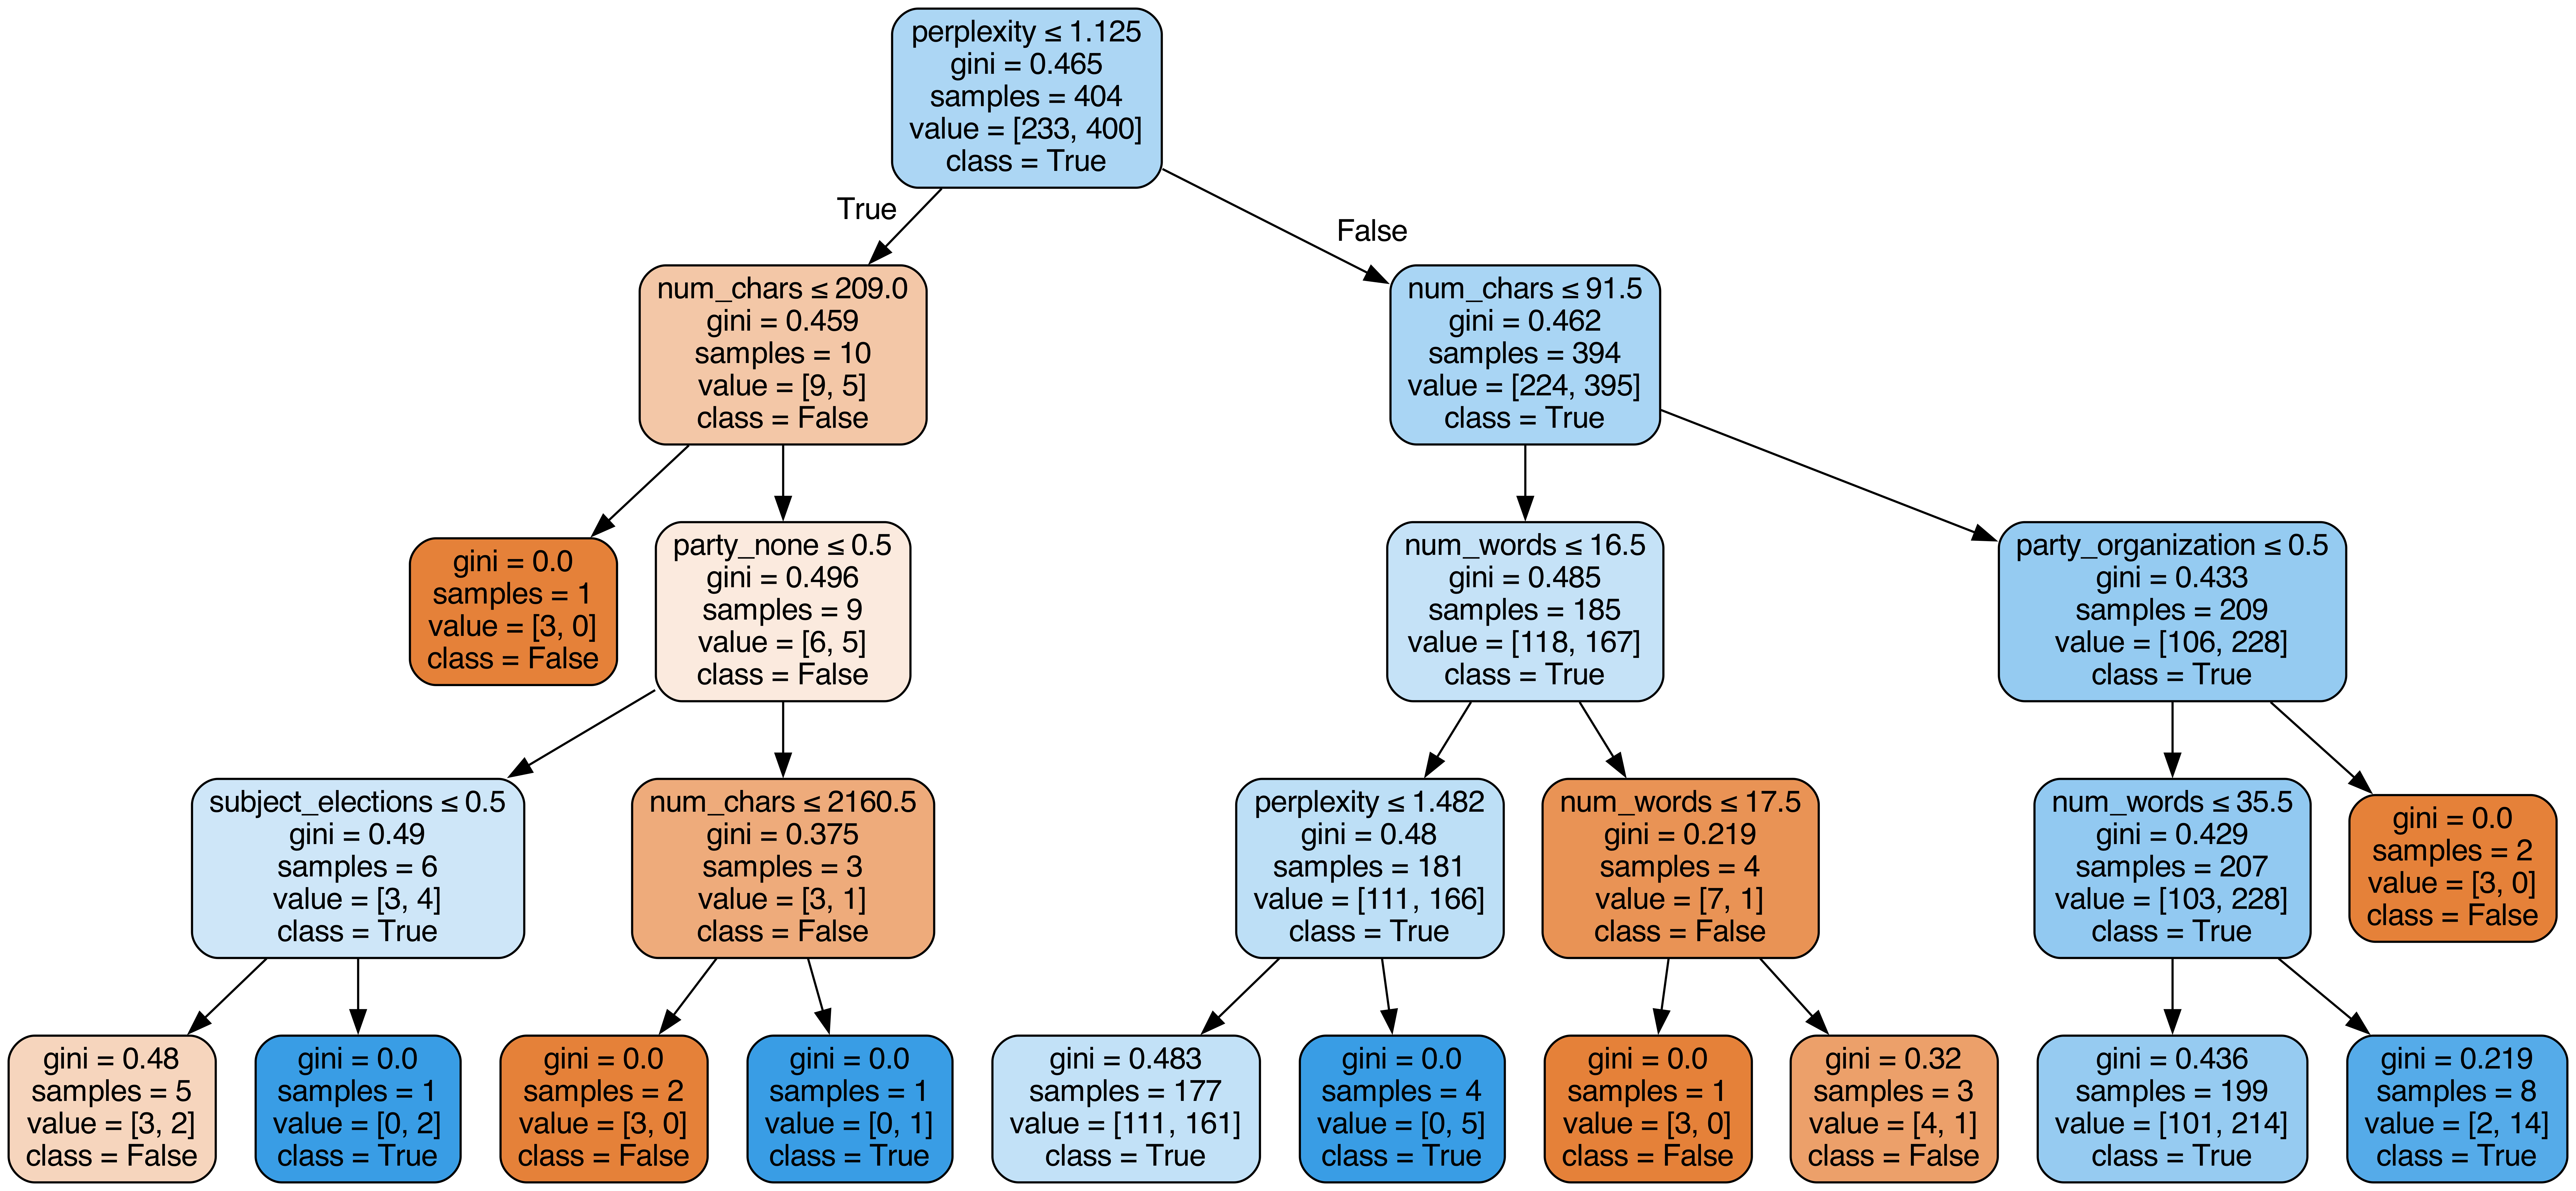

In [93]:
# show decision tree
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(rf.estimators_[0], out_file="tree.dot",
                            feature_names=new_features,
                            class_names=['False', 'True'],
                            filled=True, rounded=True,
                            special_characters=True)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [94]:
import shap

In [95]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[new_features])

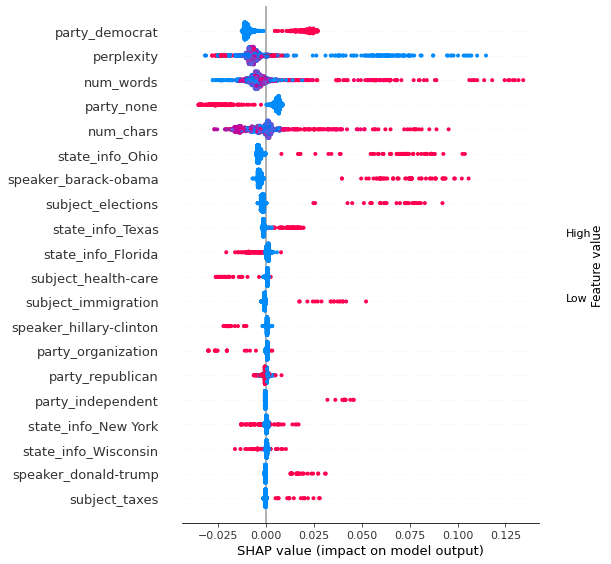

In [96]:
shap.summary_plot(shap_values[0], test[new_features], plot_type="dot")

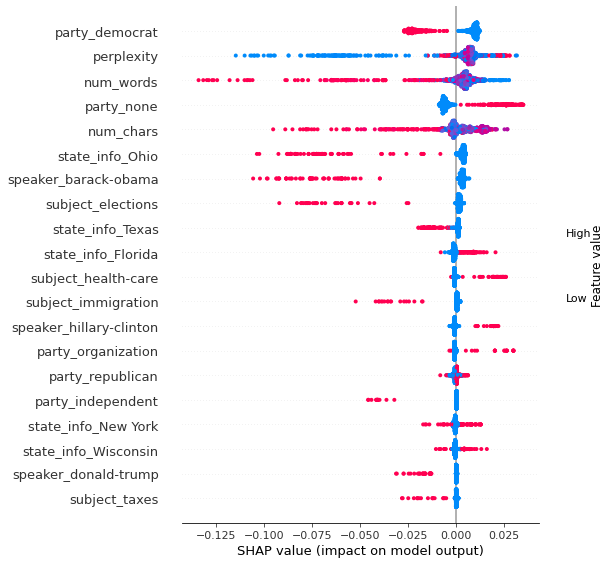

In [97]:
shap.summary_plot(shap_values[1], test[new_features], plot_type="dot")

In [40]:
test.loc[test.speaker.isin(['barack-obama', 'donald-trump', 'hillary-clinton'])].groupby('speaker')["label"].value_counts()

speaker          label
barack-obama     False    31
                 True     31
donald-trump     False    25
                 True      8
hillary-clinton  False    18
                 True     13
Name: label, dtype: int64

In [41]:
test.loc[test.speaker.isin(['barack-obama', 'donald-trump', 'hillary-clinton'])].groupby('speaker')["prediction"].value_counts()

speaker          prediction
barack-obama     False         34
                 True          28
donald-trump     False         30
                 True           3
hillary-clinton  False         21
                 True          10
Name: prediction, dtype: int64

In [47]:
test.loc[test.speaker.isin(['barack-obama', 'donald-trump', 'hillary-clinton'])].groupby('speaker')["true_pred"].value_counts()

speaker          true_pred
barack-obama     False        31
                 True         31
donald-trump     True         24
                 False         9
hillary-clinton  True         20
                 False        11
Name: true_pred, dtype: int64

In [50]:
test["meta_pred"] = rf.predict(test[new_features])

In [51]:
test.loc[test.speaker.isin(['barack-obama', 'donald-trump', 'hillary-clinton'])].groupby('speaker')["meta_pred"].value_counts()

speaker          meta_pred
barack-obama     True         52
                 False        10
donald-trump     True         33
hillary-clinton  True         31
Name: meta_pred, dtype: int64

In [160]:
test.groupby('party')["prediction"].value_counts()

party                prediction
activist             False           1
                     True            1
business-leader      True            1
columnist            False           5
                     True            2
constitution-party   False           1
county-commissioner  False           1
democrat             False         272
                     True          134
government-body      False           1
independent          False          10
                     True            4
journalist           False           7
                     True            2
libertarian          False           3
                     True            2
newsmaker            False           1
none                 False         169
                     True           45
organization         False          24
                     True            3
republican           False         472
                     True           99
state-official       False           2
                     True       